<a href="https://colab.research.google.com/github/chaalp/repo/blob/master/Copy_of_DataVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load chartevents data
d1 = files.upload()
chartevents = pd.read_csv('CHARTEVENTS.csv', low_memory=False)

# Convert 'charttime' and 'storetime' to datetime
# chartevents['charttime'] = pd.to_datetime(chartevents['charttime'], errors='coerce')
# chartevents['storetime'] = pd.to_datetime(chartevents['storetime'], errors='coerce')

# Convert 'value' column to numeric (coerce errors to NaN if conversion fails)
chartevents['value'] = pd.to_numeric(chartevents['value'], errors='coerce')

Saving CHARTEVENTS.csv to CHARTEVENTS (5).csv


In [ ]:
# Load d_items data
d2 = files.upload()
d_items = pd.read_csv('D_ITEMS.csv')

Saving D_ITEMS.csv to D_ITEMS (3).csv


In [ ]:
# Load procedureevents_mv data
d3 = files.upload()
procedureevents_mv = pd.read_csv('PROCEDUREEVENTS_MV.csv')

Saving PROCEDUREEVENTS_MV.csv to PROCEDUREEVENTS_MV.csv


In [ ]:
# Load caregivers data
d4 = files.upload()
caregivers = pd.read_csv('CAREGIVERS.csv')

Saving CAREGIVERS.csv to CAREGIVERS.csv


In [ ]:
# Load d_labitems data
d5 = files.upload()
d_labitems = pd.read_csv('D_LABITEMS.csv')

Saving D_LABITEMS.csv to D_LABITEMS.csv


In [ ]:
# Load labevents data
d6 = files.upload()
labevents = pd.read_csv('LABEVENTS.csv')

Saving LABEVENTS.csv to LABEVENTS (1).csv


## Vital Signs Over Time for Subject

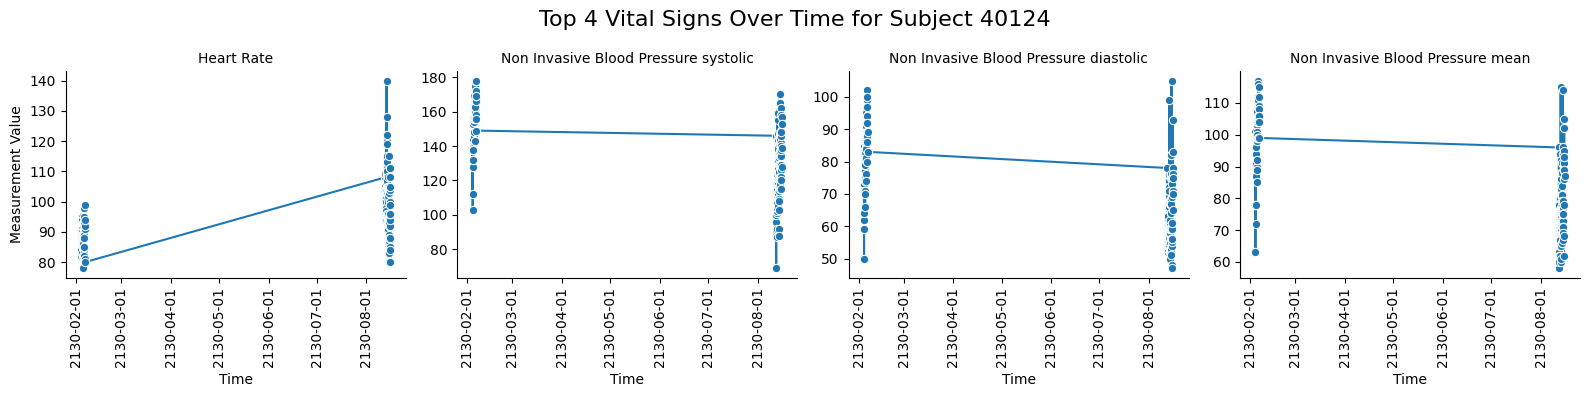

In [ ]:
# Define subject_id
subject_id = 40124  # Replace with the subject_id you want

# Merge chartevents with d_items to get the labels for each itemid
merged_data = pd.merge(chartevents, d_items[['itemid', 'label']], on='itemid', how='inner')

# Filter data for the specific subject_id
subject_data = merged_data[merged_data['subject_id'] == subject_id].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Ensure 'charttime' is in datetime format
subject_data.loc[:, 'charttime'] = pd.to_datetime(subject_data['charttime'], errors='coerce')

# Count occurrences of non-null values for each label (without using apply)
label_counts = subject_data.groupby('label')['charttime'].apply(lambda x: x.notna().sum()).reset_index(name='count')

# Sort labels by count and select the top 4
top_labels = label_counts.sort_values(by='count', ascending=False).head(4)['label']

# Filter the subject_data to include only rows for the top 4 labels
top_subject_data = subject_data[subject_data['label'].isin(top_labels)]

# Check for missing values
missing_values = top_subject_data[['charttime', 'valuenum']].isna().sum()

# Set up a FacetGrid with 'label' as the column
g = sns.FacetGrid(top_subject_data, col="label", col_wrap=4, height=4, sharex=True, sharey=False)

# Plot each vital sign in the facet grid
g.map(sns.lineplot, "charttime", "valuenum", marker='o')

# Customize the plot
g.set_axis_labels('Time', 'Measurement Value')
g.set_titles("{col_name}")
g.fig.suptitle(f'Top 4 Vital Signs Over Time for Subject {subject_id}', fontsize=16)

# Rotate the x-axis labels to make them vertical
g.set_xticklabels(rotation=90)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

## Procedure/Event Frequencies Over Time

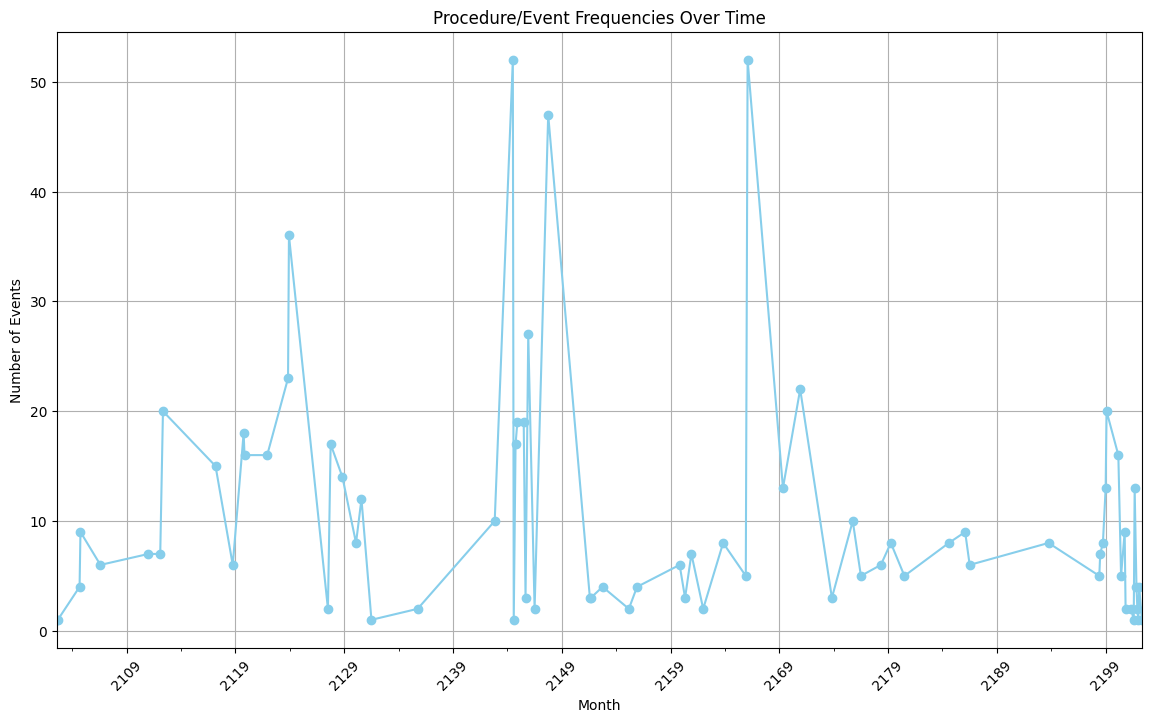

In [ ]:
# Ensure 'starttime' is a datetime column
procedureevents_mv['starttime'] = pd.to_datetime(procedureevents_mv['starttime'], errors='coerce')

# Extract year-month from the start time
procedureevents_mv['month'] = procedureevents_mv['starttime'].dt.to_period('M')

# Count the frequency of procedures per month
event_counts = procedureevents_mv.groupby('month').size()

# Plotting the number of events per month
plt.figure(figsize=(14, 8))
event_counts.plot(kind='line', marker='o', color='skyblue')
plt.title('Procedure/Event Frequencies Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Number of Procedures Performed by Each Caregiver

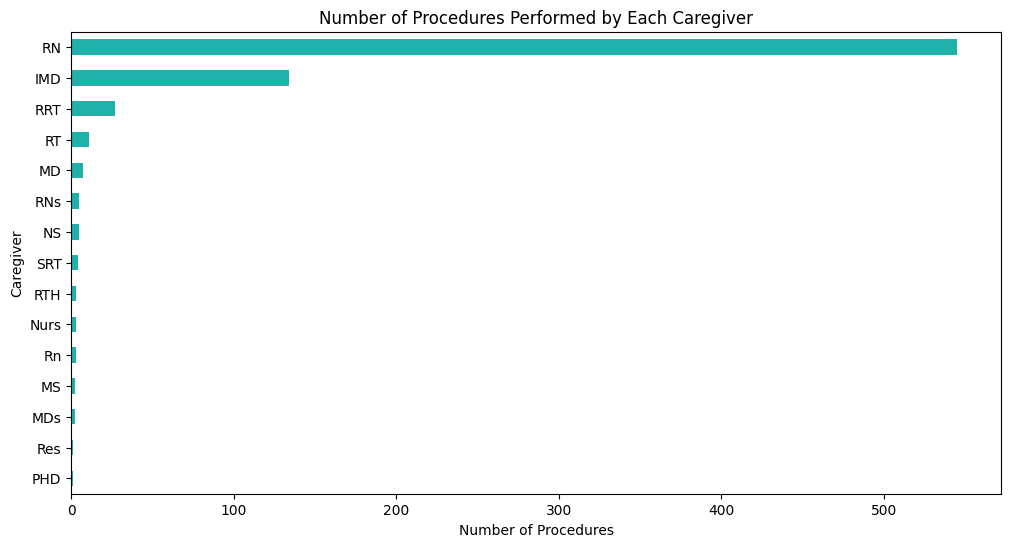

In [ ]:
# Merge with procedures dataset to get caregiver data for each procedure
procedures_df = pd.merge(procedureevents_mv, caregivers, left_on='cgid', right_on='cgid', how='left')

# Count the number of procedures for each caregiver
caregiver_counts = procedures_df['label'].value_counts()

# Horizontal bar plot
plt.figure(figsize=(12, 6))
caregiver_counts.sort_values(ascending=True).plot(kind='barh', color='lightseagreen')
plt.title('Number of Procedures Performed by Each Caregiver')
plt.xlabel('Number of Procedures')
plt.ylabel('Caregiver')
plt.show()

## Distribution of Procedure/Event Durations by Label

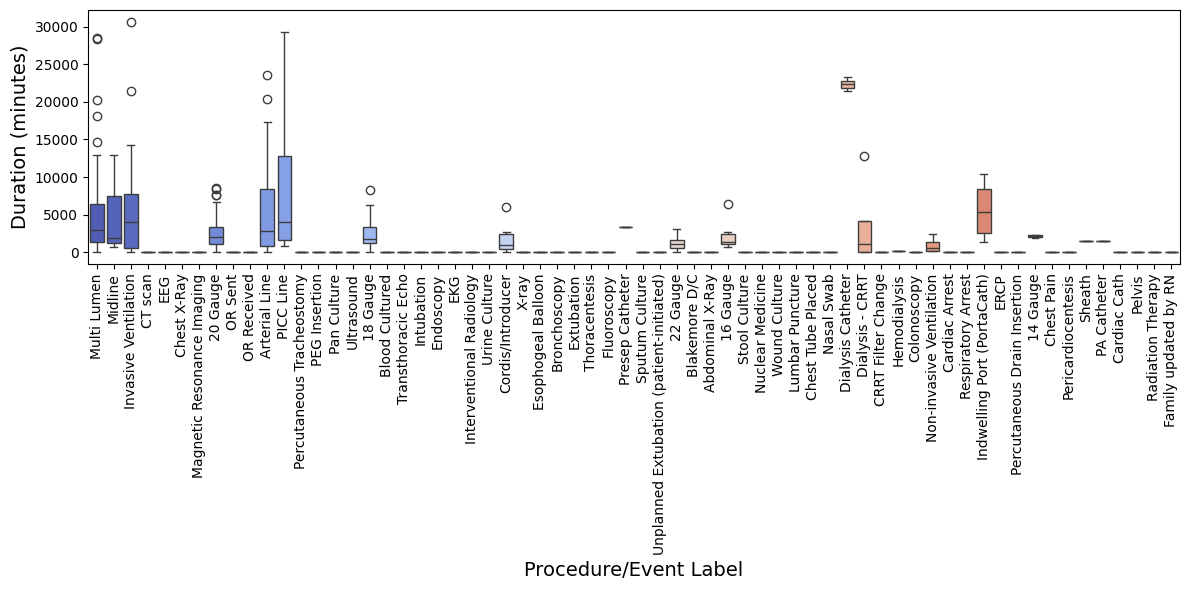

In [ ]:
# Merge the two dataframes on itemid
merged_df = pd.merge(procedureevents_mv, d_items[['itemid', 'label']], on='itemid', how='left')

merged_df['starttime'] = pd.to_datetime(merged_df['starttime'])
merged_df['endtime'] = pd.to_datetime(merged_df['endtime'])

# Calculate the duration
merged_df['duration'] = (merged_df['endtime'] - merged_df['starttime']).dt.total_seconds() / 60  # Duration in minutes

# Plot the boxplot with the correct usage of 'hue'
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='duration', data=merged_df, hue='label', palette='coolwarm', legend=False)

# Customize the plot
plt.xticks(rotation=90)  # Rotate labels for readability
plt.xlabel('Procedure/Event Label', fontsize=14)
plt.ylabel('Duration (minutes)', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

##Top 100 Most Frequent Lab Test Labels

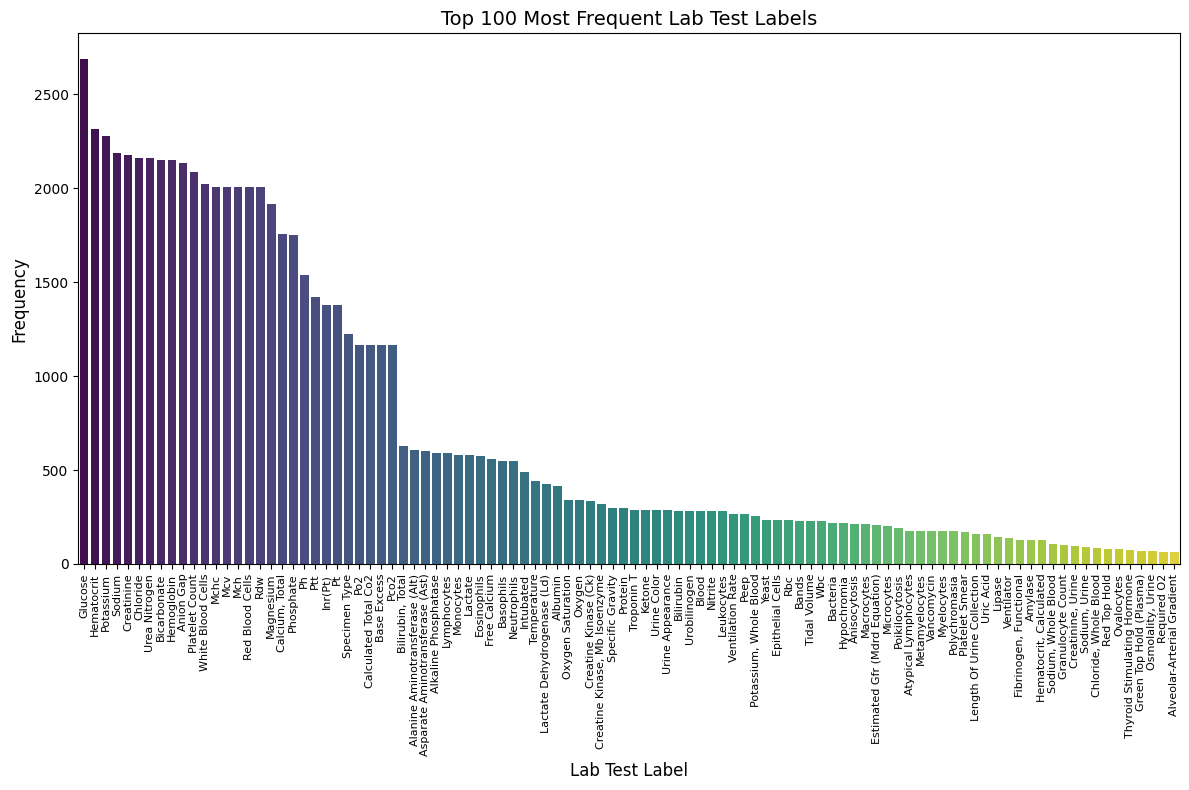

In [ ]:
# Merge datasets on 'itemid'
merged_data = pd.merge(labevents, d_labitems, on='itemid', how='inner')

# Drop NaN values in 'label' to avoid issues with empty labels
merged_data = merged_data.dropna(subset=['label'])

# Get top 100 most frequent lab test labels
top_100_labels = merged_data['label'].str.title().value_counts().head(100)

# Plot: Top 100 most frequent labels
plt.figure(figsize=(12, 8))
sns.barplot(x=top_100_labels.index, y=top_100_labels.values, palette='viridis', hue=top_100_labels.index, legend=False)

# Adjust font size for the x and y axis labels
plt.xticks(rotation=90, fontsize=8)  # Smaller font size for x-axis labels
plt.yticks(fontsize=10)  # Slightly larger font size for y-axis labels

# Add title and labels
plt.title('Top 100 Most Frequent Lab Test Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Lab Test Label', fontsize=12)

# Tight layout to ensure everything fits
plt.tight_layout()

# Show plot
plt.show()